<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/WS2_Students_EX3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import abc
import string
import statsmodels.api as sm
import itertools
from sklearn import svm, linear_model
import pandas as pd
import sys

from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Context UserModels**

In [2]:
# Generate Choice 

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    raise NotImplementedError()


In [3]:
np.random.seed(42)

# just data
def generate_synth_data(num_examples, num_features, num_items):
  items = np.random.uniform(low=0.0, high=10.0, size=(num_examples, num_items, num_features))
  return items



-----------------
-----------------

## Task 3:  behavioral bias or self-fulfilling prophecy?

In this exercise we move beyond unordered sets and set-dependent context effects, and investigate the importance of ordering on (possibly order-dependent) user behavior and on system performance.

In this section, the system provides users with an **ordered** set of items.
The system determines the order of items using a simple policy implemented in the following BaseRanker() class. Here, the rank() function takes as inputs an (unordered) set of items, and returns them in a specific order, determined by an internal parameter $\hat{\beta}$. In particular, BaseRanker() ranks items according to a linear score $\hat{\beta}^\top x$. We will think of $\hat{\beta}$ as an estimate of a user's internal value vector.

Note that BaseRanker() simply uses *some* $\hat{\beta}$, and there is no learning involved.

In [4]:
class BaseRanker():

  def __init__(self, beta_h_hat):
    self.beta_h = beta_h_hat

  def __call__(self, X):

    return X@self.beta_h
  
  def rank(self, X):
    return np.argsort(-self(X), axis=0)


The following sequence determines one round of recommendation and choice:
1. Nature generates a set of 7 items that are made available in this round (different set every round)
2. System orders these items using BaseRanker
3. Items are displayed to the user as an ordered list
4. User selects an item from the ordered list
5. System stores (i) the chosen item, and (ii) the item's position in the ordered list

In this section, choices are generated by an **unknown** user model called XUserModel, which chooses from ordered lists generated by a BaseRanker ranker (having some internal $\hat{\beta}$).
The next block of code loads an array describing the positions (within the ordered list) of the items chosen by xuser across multiple rounds. 

In [5]:
!unzip x_user_click_positions.npy.zip

Archive:  x_user_click_positions.npy.zip
replace x_user_click_positions.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._x_user_click_positions.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
x_user_choice_positions = np.load('x_user_click_positions.npy')

3.0.1 Plot a histogram of position counts: position of chosen item on the x-axis, number of times this position appeared accross all rounds in the y-axis.



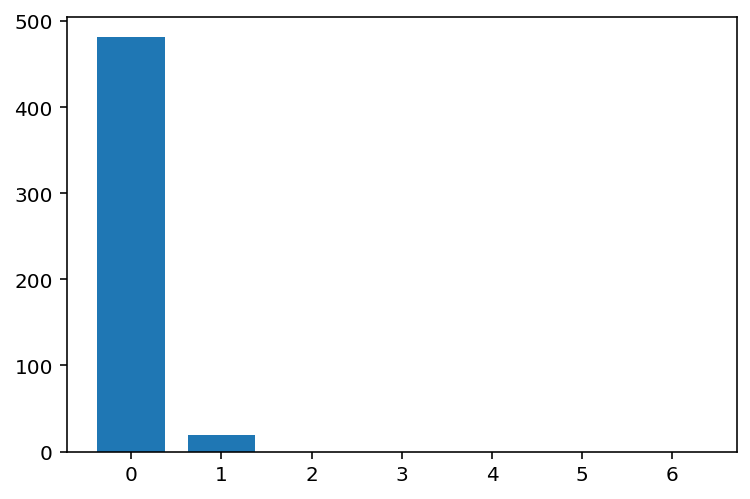

In [7]:
import matplotlib.pyplot as plt

_, axs = plt.subplots()
axs.hist(x_user_choice_positions, bins=[i - 0.5 for i in range(7)] + [6.5], rwidth=0.75)
axs.set_xticks(list(range(7)))
axs.set_xticklabels([str(i) for i in range(7)])
plt.show()

3.0.2 Does user behavior showcase order bias? What type?
Explain your answer.

Answer: User tend to choose the first item she see. In some cases she chooses the second item she see, and never choose later items.

### 3.1 Predicting choices

Next, let's examine how well we can predict choice behavior in this setting.
We will provide you with functions that:
* Generate inputs of sets of items
* Ranks them (transforming them into ordered lists)
* Generates choices and item positions (using query-access to an XUser Model)
* A learning algorithm for predicting choice


First, load into memory an instance of xuser of the class XUserModel. **This code his hidden from you** - consider xuser as a black box which you may only use to generate choice behavior for ordered list inputs. We will later use th xuser.select(X) function to generate choices.


To load xuser, **follow these steps carefully:**
1. Press the 'Play' icon to run the block of code
2. Do **NOT** double click on the title (we will see if you did this...)
3. You may **NOT** access xuser's code in any other way, modify it, or change xuser's instantiation.

In [8]:
#@title xuser


class XUserModel(UserModel):

  def __init__(self, num_features, beta_h, c, beta_p, c_p=0):
    self.num_features = num_features
    self.beta_1 = np.arange(num_features)
    self.beta_2 = beta_p
    self.c = c
    self.c1 = c_p
    self.beta_3 = self.beta_1 + self.c * self.beta_2

  def __call__(self, X):
    pos = np.arange(X.shape[0])
    z = X@self.beta_1
    z_ = X@self.beta_3 + self.c*pos
    z_ip = z_ + self.c* np.random.randn(X.shape[0])
    z_p = z + self.c* np.random.randn(X.shape[0])
    b = z_ip + z_p 
    z_b = z_p + self.c1*b
    return z_b
  
  def select(self, X):
    return np.argmax(self(X), axis=0)

beta_h = np.arange(5)
xuser = XUserModel(5, beta_h, c=0.7, beta_p=beta_h)

Next, generate data. The next block of code generates items sets, orders them as lists use BaseRanker, and generate choices using xuser:


In [9]:
np.random.seed(42)
num_features = 5
num_items =7
num_rounds = 500

# generate data:
X = generate_synth_data(num_rounds, num_features, num_items)

# order items:
beta_h = np.arange(num_features) #arbitrary
base_ranker = BaseRanker(beta_h)
X_display = list()
y_x = np.ones((num_rounds, num_items)) * 2 # holds ground truth
y_idx = np.zeros(num_rounds)

# for each round, order items and generate user choices:
for i in range(X.shape[0]):
  ranks = base_ranker.rank(X[i])
  X_display.append(X[i][ranks])
  selection = xuser.select(X_display[i])
  y_x[i, selection] = 1
  y_idx[i] = selection

Next, initialize a predictive model.

In this section our predcitive model will use a pair-wise partial ranking method implemented in the XGBoost ranker (this is a widely-used machine learning library based on gradient boosting). Note that this method (just like your pair-wise ranker implementation) does *not* take item positions into account.

The next blocks of code load the xgboost package, initializes a model, and define two helper functions: prep_xgboost_data() which prepares inputs to be in a format that xgboost uses; and eval_xgboost(), which evaluates the performance of a learned model. We will use these later.

**No need to go over this code! Just run the cells.**

In [10]:

import xgboost as xgb

class_weights = {1:100, 2:10}

model = xgb.XGBRanker(  
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75,
    class_weights =  class_weights
    )

In [11]:
from sklearn.model_selection import GroupShuffleSplit

def prep_xgboost_data(X,y_x,y_idx):
  # x_user_click_positions = np.zeros(X.shape[0])
  X_flatten = np.zeros((X.shape[1]*X.shape[0], X.shape[2]+1))

  # round_id is inserted so predictions would be made per group
  X_flatten[:,0] = np.repeat(np.arange(num_rounds), num_items)
  X_flatten[:,1:] = np.vstack(X)
  df = pd.DataFrame(X_flatten)

  np.random.seed(42)
  df['rank'] = y_x.flatten()
  df.rename(columns={0:'id'}, inplace=True)
  gss = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = 42).split(df, groups=df['id'])
  X_train_inds, X_test_inds = next(gss)
  train_data = df.iloc[X_train_inds]
  X_test = df.iloc[X_test_inds]
  y_test = y_idx[X_test['id'].unique().astype(int)]

  X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank'])]
  y_train = train_data.loc[:, train_data.columns.isin(['rank'])]
  groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()
  return X_train, y_train, X_test, y_test, groups


def eval_xgboost(X_, y_):
  def predict_xgboost(model, X_):
      return model.predict(X_.loc[:, ~X_.columns.isin(['id'])])
  # test model
  test_features= X_.loc[:, ~X_.columns.isin(['rank'])]
  test_group_ids = X_test['id'].unique()

  pred_values = (test_features.groupby('id').apply(lambda x: predict_xgboost(model, x)))

  # translate to predictions
  yhat = pred_values.apply(lambda x: np.argmin(x))
  # evaluate accuracy
  acc = np.sum(yhat == y_)/len(y_)
  return yhat, acc


Finally, train and evaluate the performance of the model.

In [12]:
# prep data
X_train, y_train, X_test, y_test, groups = prep_xgboost_data(X,y_x,y_idx)

# fit model
model.fit(X_train, y_train, group=groups, verbose=True)

# evaluate
yhat, acc = eval_xgboost(X_test, y_test)
print(acc)

0.19333333333333333


3.1.1 In this section, we will try to improve predictive performance by utilizing the position items in the ordered lists as additional input.

Augment the input data by adding to each item an additional feature that encodes the position of that item in the list to which it belongs. This is a very simple procedure - note that the information exists in X, since the position of the item is simply its index in the array.

Run xgboost on this new data, and compare performance.

In [13]:
# augment inputs with item positions as an additional feature
def augment_with_positions(X):
  Xnew = np.concatenate((X, np.zeros((X.shape[0], X.shape[1], 1))), axis=2)
  for i in range(X.shape[0]):
    ranks = base_ranker.rank(X[i])
    Xnew[i][:,-1] = ranks
  return Xnew

X_aug = augment_with_positions(X)

# prep data
X_train2, y_train2, X_test2, y_test2, groups2 = prep_xgboost_data(X_aug, y_x, y_idx)

# fit model
model.fit(X_train2, y_train2, group=groups2, verbose=True)

# evaluate
yhat2, acc2 = eval_xgboost(X_test2, y_test2)
print(acc2)

0.22


Did adding position as a feature impropve performance? Explain why.

Answer: Yes, it improved the accuracy from 0.19 to 0.22. It makes sense, since now the learner gets information about the position on the item in the set,
and we know that this information is critical for the user decision (non-rational model in data generation).

3.1.3 In this section we will repeat the same procedure, but this time, **without** ranking items using BaseRanker (that is, user receives a list of items in their initial, unsorted order).

In [33]:
np.random.seed(42)

# generate data:
X = generate_synth_data(num_rounds, num_features, num_items)

# order items:
X_display = list()
y_x = np.ones((num_rounds, num_items)) * 2 # holds ground truth
y_idx = np.zeros(num_rounds)

# for each round, order items and generate user choices:
for i in range(X.shape[0]):
  ranks = base_ranker.rank(X[i])
  X_display.append(X[i][ranks])
  # We commented out this line (we consider it as a typo) because it doesnt make sense.
  # This code block is exactly the same as the previous one beneath the model import.
  selection = xuser.select(X_display[i])  
  # selection = xuser.select(X[i])
  y_x[i, selection] = 1
  y_idx[i] = selection

 Plot a histogram of position counts:

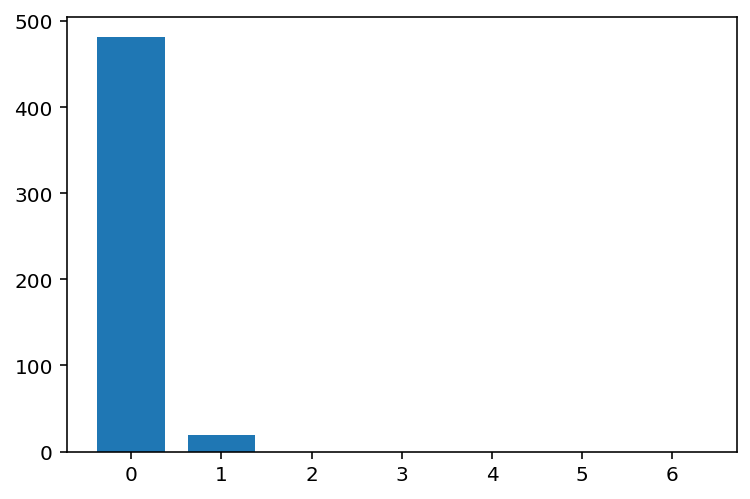

In [34]:
_, axs = plt.subplots()
axs.hist(y_idx, bins=[i - 0.5 for i in range(7)] + [6.5], rwidth=0.75)
axs.set_xticks(list(range(7)))
axs.set_xticklabels([str(i) for i in range(7)])
plt.show()

Does the plot align with your expectations? Explain your observations.

Answer: Yes, now we observe no bias towards any specific position (rational). 

3.1.4 Train and evaluate a new xgboost model, once **without** positions as a featuere, and once **with** position as a feature. Use your code for augmenting the data from above.

Compare the performance of both approaches.

In [35]:
# train model and evaluate *without* position bias as a feature
X_train, y_train, X_test, y_test, groups = prep_xgboost_data(X, y_x, y_idx)
print(X_train.head())
print(X_train.describe())
print(y_train.head())
print(y_train.describe())
model.fit(X_train, y_train, group=groups, verbose=True)
yhat, acc = eval_xgboost(X_test, y_test)
print(acc)

           1         2         3         4         5
7   8.083973  3.046138  0.976721  6.842330  4.401525
8   1.220382  4.951769  0.343885  9.093204  2.587800
9   6.625223  3.117111  5.200680  5.467103  1.848545
10  9.695846  7.751328  9.394989  8.948274  5.979000
11  9.218742  0.884925  1.959829  0.452273  3.253303
                 1            2            3            4            5
count  2450.000000  2450.000000  2450.000000  2450.000000  2450.000000
mean      4.928328     4.947750     5.113018     5.099921     4.972993
std       2.899121     2.889027     2.926435     2.847524     2.883607
min       0.002270     0.000307     0.002409     0.001577     0.001347
25%       2.499625     2.389876     2.543450     2.650380     2.491822
50%       4.923741     5.038040     5.251258     5.199514     4.920461
75%       7.458417     7.415572     7.635509     7.573031     7.489558
max       9.998051     9.977494     9.995052     9.999248     9.994137
    rank
7    1.0
8    2.0
9    2.0
10   2.

In [36]:
# train model and evaluate *with* position bias as a feature
X_aug = augment_with_positions(X) #USES YOUR FUNCTION FROM ABOVE
X_train2, y_train2, X_test2, y_test2, groups2 = prep_xgboost_data(X_aug, y_x, y_idx)
print(X_train2.head())
print(X_train2.describe())
print(y_train2.head())
print(y_train2.describe())
model.fit(X_train2, y_train2, group=groups2, verbose=True)
yhat2, acc2 = eval_xgboost(X_test2, y_test2)
print(acc2)

           1         2         3         4         5    6
7   8.083973  3.046138  0.976721  6.842330  4.401525  3.0
8   1.220382  4.951769  0.343885  9.093204  2.587800  6.0
9   6.625223  3.117111  5.200680  5.467103  1.848545  1.0
10  9.695846  7.751328  9.394989  8.948274  5.979000  0.0
11  9.218742  0.884925  1.959829  0.452273  3.253303  5.0
                 1            2  ...            5            6
count  2450.000000  2450.000000  ...  2450.000000  2450.000000
mean      4.928328     4.947750  ...     4.972993     3.000000
std       2.899121     2.889027  ...     2.883607     2.000408
min       0.002270     0.000307  ...     0.001347     0.000000
25%       2.499625     2.389876  ...     2.491822     1.000000
50%       4.923741     5.038040  ...     4.920461     3.000000
75%       7.458417     7.415572  ...     7.489558     5.000000
max       9.998051     9.977494  ...     9.994137     6.000000

[8 rows x 6 columns]
    rank
7    1.0
8    2.0
9    2.0
10   2.0
11   2.0
         

Explain your results.

In [18]:
Answer: ...

### 3.2 User Behavior Analysis

In the previous tasks you examined the relationship between postion in the list and choice behavior. While plotting them together may *suggest* of a possible connection between them, one cannot infer the *cause* for this relationship.

**Don't confuse correlation with causation!**

3.2.1 Write an algorithm that *determines* whether a user model *really* exhibits order bias, and attempt to quantify the extent of this bias.

**Think**: How should you approach this?

Start by explicitly writing your approach (in text), and only then proceed to writing this in code.

**Hint**: You can use the given xuser to run "experiments".

In [19]:
Answer:...

In [20]:
"""

YOUR CODE 
"""

'\n\nYOUR CODE \n'

3.2.2 Now that you've implemented your validation procedure, use it to determine which of the following **three user models** (called 'click models') are prone to order bias, and to what extent.

Explain your results, and support your claims using appropriate bar plot(s).

In [21]:
# click-model classes

class AUserModel(UserModel):
  def __init__(self, num_features):
    self.num_features = num_features
    
  def __call__(self, X):
    return 1

  def select(self, X):
    return 1

class BUserModel(UserModel):
  def __init__(self,beta_h=np.arange(num_features), c=5):
    print(f'beta_h: {beta_h}')
    self.num_features = num_features
    self.beta_h = beta_h
    self.c = c

  def __call__(self, X):

    return X@np.arange(num_features) - self.c*np.arange(X.shape[0])
  
  def select(self, X):
    return np.argmax(self(X), axis=0)

class CUserModel(UserModel):

  def __init__(self,beta_h=np.arange(num_features)):
    self.num_features = num_features
    self.beta_h = beta_h

  def __call__(self, X):
    penalty = np.zeros(X.shape[0])
    penalty[1] = 8
    return X@np.arange(num_features) - penalty
  
  def select(self, X):
    return np.argmax(self(X), axis=0)


In [22]:
beta_h = np.arange(num_features)
a_click_user = AUserModel(num_features)
b_click_user = BUserModel(num_features)
c_click_user = CUserModel(num_features)

beta_h: 5


In [23]:
"""

YOUR IMPLEMNTATION GOES HERE

"""

'\n\nYOUR IMPLEMNTATION GOES HERE\n\n'

Run your procedure on the three user models:

In [24]:
"""

YOUR CODE GOES HERE

"""

'\n\nYOUR CODE GOES HERE\n\n'

Provide relevant plots:

In [25]:
"""
YOUR PLOT
"""

'\nYOUR PLOT\n'